# NOT-Example 
## Finally some Code!

In [20]:
import qiskit

In [8]:
import numpy as np

X_train = np.asarray([[1.0, 1.0], [-1.0, 1.0], [-1.0, -1.0], [1.0, -1.0]])
y_train = [0, 1, 0, 1]

X_test = np.asarray([[0.2, 0.4], [0.4, -0.8]])
y_test = [0, 1]

from dc_qiskit_qml.encoding_maps import EncodingMap
import scipy.sparse as sparse


class MyEncodingMap(EncodingMap):
        def map(self, input_vector: list) -> sparse.dok_matrix:
            result = sparse.dok_matrix((4,1))
            index = 0
            if input_vector[0] > 0 and input_vector[1] > 0:
                index = 0
            if input_vector[0] < 0 < input_vector[1]:
                index = 1
            if input_vector[0] < 0 and input_vector[1] < 0:
                index = 2
            if input_vector[0] > 0 > input_vector[1]:
                index = 3
            result[index, 0] = 1.0
            return result


encoding_map = MyEncodingMap()

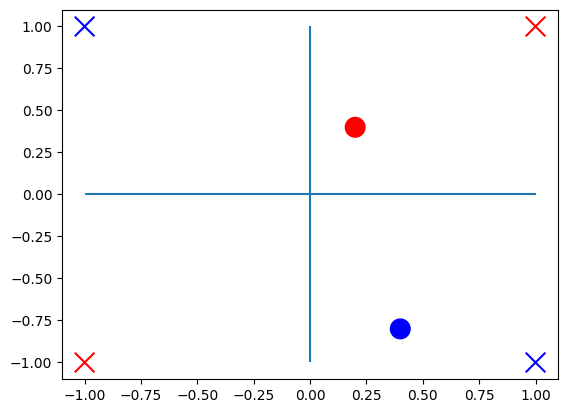

In [9]:
import matplotlib.pyplot as plt

plt.scatter(
    X_train[:,0], X_train[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_train],
    marker='x', s=200)
plt.scatter(
    X_test[:,0], X_test[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_test],
    marker='o', s=200)
plt.hlines(0.0, -1.0, 1.0)
plt.vlines(0.0, -1.0, 1.0)
plt.show()

In [10]:
from qiskit_aer.backends.aerbackend import AerBackend
from dc_qiskit_qml.distance_based.hadamard import QmlHadamardNeighborClassifier
from dc_qiskit_qml.distance_based.hadamard.state import QmlBinaryDataStateCircuitBuilder
from dc_qiskit_qml.distance_based.hadamard.state.cnot import CCXToffoli

initial_state_builder = QmlBinaryDataStateCircuitBuilder(CCXToffoli(), do_optimizations=False)

execution_backend: AerBackend = qiskit.Aer.get_backend('qasm_simulator')
qml = QmlHadamardNeighborClassifier(backend=execution_backend,
                                    shots=8192,
                                    encoding_map=encoding_map,
                                    classifier_circuit_factory=initial_state_builder)

qml.fit(X_train, y_train)
qml.predict(X_test), y_test

([0, 1], [0, 1])

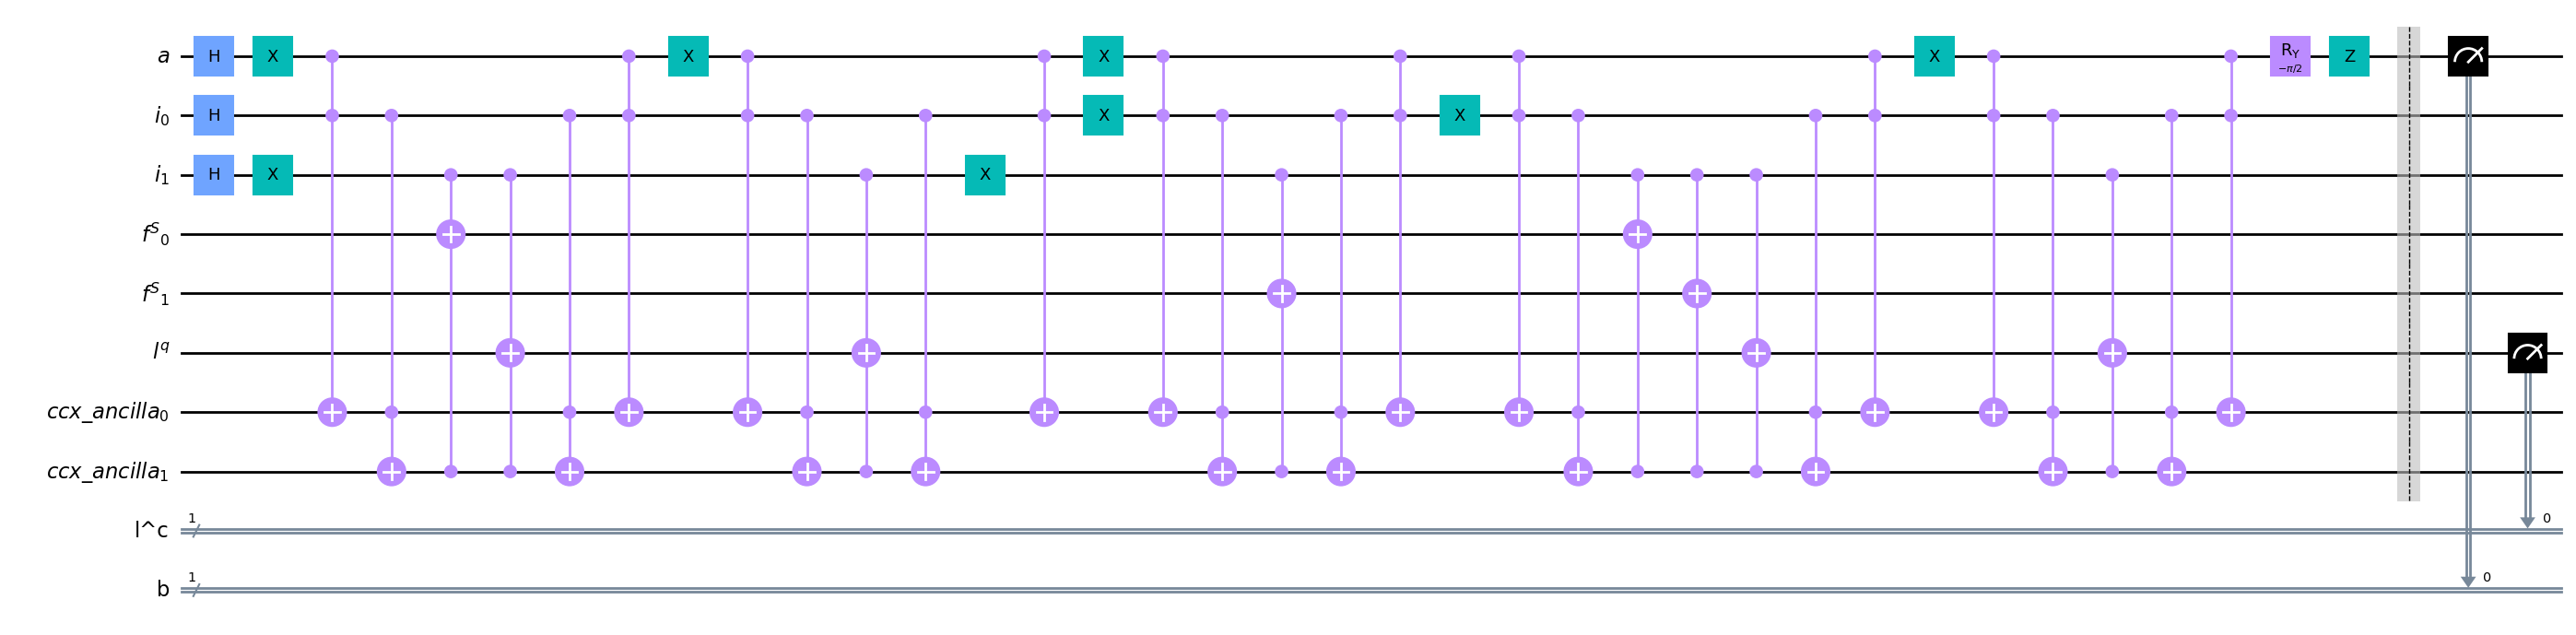

In [15]:
qml._last_predict_circuits[0].draw(output='mpl', fold=-1)

## With optimizations

In [12]:
initial_state_builder = QmlBinaryDataStateCircuitBuilder(CCXToffoli(), do_optimizations=True)

execution_backend: AerBackend = qiskit.Aer.get_backend('qasm_simulator')
qml = QmlHadamardNeighborClassifier(backend=execution_backend,
                                    shots=8192,
                                    encoding_map=encoding_map,
                                    classifier_circuit_factory=initial_state_builder)

qml.fit(X_train, y_train)
qml.predict(X_test), y_test

([0, 1], [0, 1])

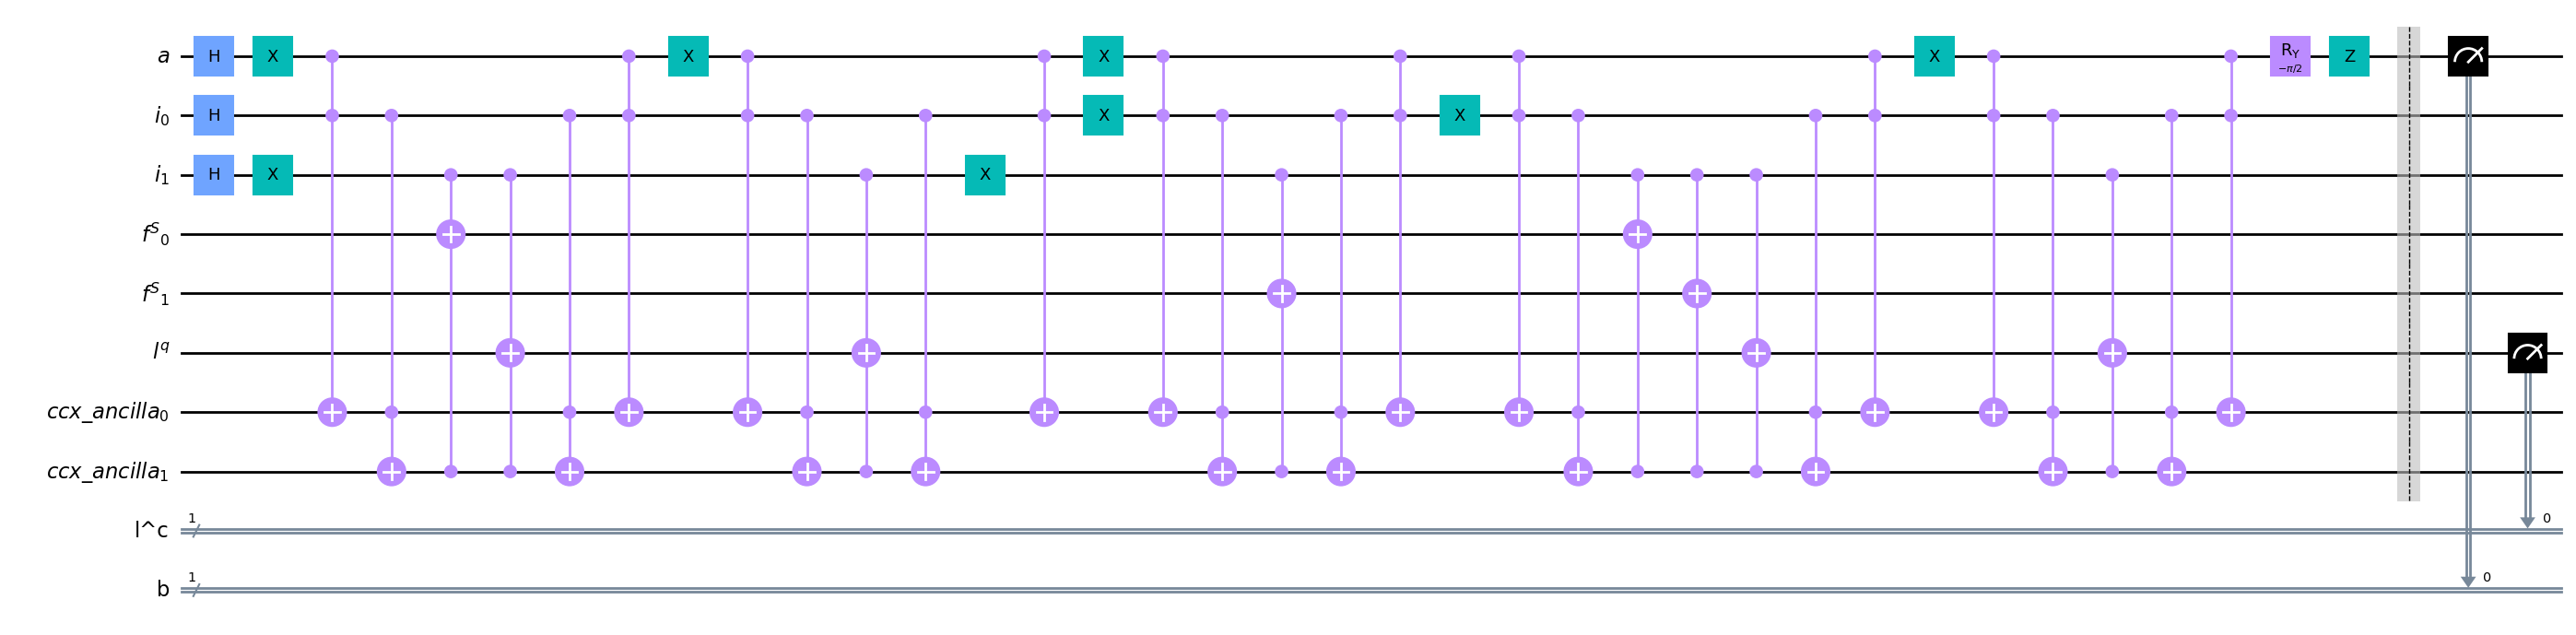

In [14]:
qml._last_predict_circuits[0].draw(output='mpl', fold=-1)

## Compiled for usage on real processor

In [17]:
from qiskit_ibm_provider import IBMProvider, IBMBackend

provider : IBMProvider = IBMProvider()
ibm_brisbane: IBMBackend = provider.get_backend('ibm_brisbane')

In [18]:
transpiled_qc = qiskit.transpile(qml._last_predict_circuits[0], backend=ibm_brisbane)
qobj = qiskit.assemble(transpiled_qc, backend=ibm_brisbane)

In [23]:
print("Number of gates: {}.\n".format(len(transpiled_qc.data)))

Number of gates: 2081.
